<a href="https://colab.research.google.com/github/rihat99/openai_gym/blob/main/MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

!pip install box2d-py
import gym

env = gym.make('MountainCar-v0')
# tf.random.set_seed(42)
# np.random.seed(42)
# env.seed(42)
!python --version
print(tf.__version__)
print(gym.__version__)

     |████████████████████████████████| 450kB 9.1MB/s 
Python 3.7.10
2.4.1
0.17.3


In [2]:
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

Size of State Space ->  2
Size of Action Space ->  3


In [3]:
K = keras.backend

def DDQN():
    input_states = keras.layers.Input(shape=[num_states])
    hidden1 = keras.layers.Dense(256, activation="elu")(input_states)
    #hidden1 = keras.layers.Dropout(0.1)(hidden1)
    hidden2 = keras.layers.Dense(128, activation="elu")(hidden1)
    #hidden2 = keras.layers.Dropout(0.1)(hidden2)
    hidden3 = keras.layers.Dense(16, activation='elu')(hidden2)
    #hidden3 = keras.layers.Dropout(0.1)(hidden3)
    state_values = keras.layers.Dense(1)(hidden3)
    raw_advantages = keras.layers.Dense(num_actions)(hidden3)
    advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
    Q_values = state_values + advantages
    model = keras.Model(inputs=[input_states], outputs=[Q_values])
    return model

In [4]:
from collections import deque

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        self.replay_memory = deque(maxlen=self.buffer_capacity)
        

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        self.replay_memory.append(obs_tuple)

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        next_Q_values = model(next_state_batch, training=True)
        best_next_actions = tf.math.argmax(next_Q_values, axis=1)
        next_mask = tf.one_hot(best_next_actions, num_actions)
        next_best_Q_values = tf.reduce_sum(target_model(next_state_batch, training=True) * next_mask,
                                            axis=1)
        target_Q_values = (reward_batch +
                       (1 - done_batch) * gamma * next_best_Q_values)
        target_Q_values = tf.reshape(target_Q_values, (-1, 1))
        mask = tf.one_hot(action_batch, num_actions)
        with tf.GradientTape() as tape:
            all_Q_values = model(state_batch)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.math.reduce_mean(loss_fn(target_Q_values,Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
         # Get sampling range
        record_range = min(len(self.replay_memory), self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        batch = [self.replay_memory[index] for index in batch_indices]
        states, actions, rewards, next_states, dones = map(list, zip(*batch))

        # Convert to tensors
        state_batch = tf.convert_to_tensor(states)
        action_batch = tf.convert_to_tensor(actions)
        action_batch = tf.cast(action_batch, dtype=tf.int32)
        reward_batch = tf.convert_to_tensor(rewards)
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(next_states)
        done_batch = tf.convert_to_tensor(dones)
        done_batch = tf.cast(done_batch, dtype=tf.float32)

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        Q_values = model.predict(state)
        return np.argmax(Q_values[0])

In [6]:
model = DDQN()
target_model = DDQN()

# Making the weights equal initially
target_model.set_weights(model.get_weights())

# Learning rate for actor-critic models
model_lr = 0.0003
optimizer = tf.keras.optimizers.Adam(model_lr)
loss_fn = keras.losses.mean_squared_error

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.992
tau = 0.0025
update_rate = 1

buffer = Buffer(100000, 128)

from IPython.display import clear_output
ep_reward_list = []
avg_reward_list = []
best_score = -200
best_weights = model.get_weights()

Episode: 999 Current Reward: -111.0
Average_reward:  -118.05


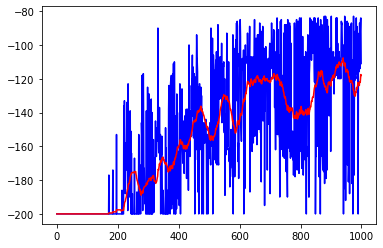

In [7]:
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0
    step = 0
    while True:

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, epsilon)
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state, done))
        episodic_reward += reward

        if step % update_rate == 0:
            buffer.learn()
            #update_target(model.variables, target_model.variables, tau)

        prev_state = state
        step += 1
        if done:
            break

    epsilon = max(0.001, epsilon*epsilon_decay)
    target_model.set_weights(model.get_weights())

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    clear_output(wait=True)
    print('Episode:', ep, 'Current Reward:', episodic_reward)
    print('Average_reward: ', avg_reward)
    
    if avg_reward > best_score:
        best_weights = model.get_weights()
        best_score = avg_reward
    plt.plot(np.arange(len(ep_reward_list)),ep_reward_list, 'b',
             np.arange(len(avg_reward_list)), avg_reward_list, 'r')
    plt.show()


In [8]:
actual_weights = model.get_weights()
model.save('ActualLunarLander')
final_model = keras.models.clone_model(model)
final_model.set_weights(best_weights)
final_model.save('LunarLander')
print(best_score)

INFO:tensorflow:Assets written to: ActualLunarLander/assets
INFO:tensorflow:Assets written to: LunarLander/assets
-107.625


In [10]:
reconstructed_model = keras.models.load_model('ActualLunarLander')

def smart_policy(obs):
    Q_values = reconstructed_model.predict(obs[np.newaxis])
    return np.argmax(Q_values[0])

totals = []
for episode in range(100):
    episode_reward = 0
    obs = env.reset()
    while True:
        action = smart_policy(obs)
        obs, reward, done, info = env.step(action)
        #env.render()
        episode_reward += reward
        if done:
            break
    print(episode_reward)
    totals.append(episode_reward)

env.close()

import numpy as np
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

-116.0
-91.0
-91.0
-114.0
-92.0
-86.0
-88.0
-86.0
-115.0
-91.0
-83.0
-105.0
-124.0
-104.0
-115.0
-109.0
-112.0
-119.0
-115.0
-117.0
-113.0
-115.0
-103.0
-124.0
-88.0
-84.0
-114.0
-84.0
-117.0
-114.0
-116.0
-114.0
-83.0
-87.0
-92.0
-84.0
-118.0
-105.0
-89.0
-105.0
-86.0
-115.0
-119.0
-94.0
-97.0
-117.0
-108.0
-84.0
-118.0
-84.0
-104.0
-104.0
-115.0
-113.0
-112.0
-124.0
-93.0
-104.0
-114.0
-114.0
-89.0
-92.0
-117.0
-83.0
-100.0
-87.0
-115.0
-86.0
-107.0
-114.0
-88.0
-105.0
-97.0
-106.0
-98.0
-85.0
-110.0
-107.0
-98.0
-106.0
-115.0
-85.0
-105.0
-117.0
-118.0
-83.0
-124.0
-121.0
-86.0
-118.0
-91.0
-123.0
-114.0
-107.0
-106.0
-112.0
-115.0
-104.0
-114.0
-85.0
-103.74 12.98200292712954 -124.0 -83.0


In [11]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

from colabgymrender.recorder import Recorder

directory = './video'
video_env = Recorder(env, directory)

  Created wheel for colabgymrender: filename=colabgymrender-1.0.8-cp37-none-any.whl size=2511 sha256=876ede9236175a7184d72f544c2a4cf2306f7a0f5242a206bbf9f92f182ac117
  Stored in directory: /root/.cache/pip/wheels/8a/d1/e8/ef1d4f6e536cc6b965b28c859ccd2a7f7ab123b94ef4007712
Successfully built colabgymrender
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2547712/45929032 bytes (5.5%)6709248/45929032 bytes (14.6%)10821632/45929032 bytes (23.6%)14827520/45929032 bytes (32.3%)18948096/45929032 bytes (41.3%)23109632/45929032 bytes (50.3%)27246592/45929032 bytes (59.3%)

In [14]:
obs = video_env.reset()
while True:
    action = np.argmax(model(obs[np.newaxis])[0])
    obs, reward, done, info = video_env.step(action)
    if done:
        break

video_env.play()

100%|██████████| 115/115 [00:00<00:00, 393.52it/s]
